In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import joblib
from time import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# NN dependencies
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
df = pd.read_csv('estm_feat.csv')
df

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference,composition,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,BiSb(Se0.92Br0.08)3,300.0,-110.00,27766.0,0.6300,0.000336,0.159985,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
1,BiSb(Se0.92Br0.08)3,400.0,-138.00,23883.0,0.5700,0.000455,0.319177,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
2,BiSb(Se0.92Br0.08)3,500.0,-163.00,20850.0,0.5300,0.000554,0.522607,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
3,BiSb(Se0.92Br0.08)3,600.0,-181.00,19000.0,0.5100,0.000622,0.732305,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
4,BiSb(Se0.92Br0.08)3,700.0,-193.00,17925.0,0.5000,0.000668,0.940000,10.1002/adfm.201806558,Bi1 Sb1 Se2.76 Br0.24,34,...,0.0,0.0,0.0,0.0,12,166,154,46.400000,49.529600,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,Ge9Sb2Te12,423.0,77.28,173636.0,2.8586,0.001037,0.153448,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5201,Ge9Sb2Te12,525.0,97.50,136364.0,2.7576,0.001296,0.246795,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5202,Ge9Sb2Te12,625.0,112.88,120000.0,2.8232,0.001529,0.338496,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152
5203,Ge9Sb2Te12,725.0,135.19,108182.0,2.5354,0.001977,0.565374,https://doi.org/10.1021/acsami.0c02155,Ge9 Sb2 Te12,32,...,0.0,0.0,0.0,0.0,152,225,73,181.782609,33.822306,152


In [3]:
df.iloc[4308]

Formula                                Ba0.03Co4Sb12
temperature(K)                                 300.0
seebeck_coefficient(μV/K)                    -219.66
electrical_conductivity(S/m)                 39900.0
thermal_conductivity(W/mK)                    5.4135
                                           ...      
MagpieData maximum SpaceGroupNumber              229
MagpieData range SpaceGroupNumber                 63
MagpieData mean SpaceGroupNumber          173.104803
MagpieData avg_dev SpaceGroupNumber         10.63726
MagpieData mode SpaceGroupNumber                 166
Name: 4308, Length: 141, dtype: object

In [40]:
X_np = df[df.columns[9:]].to_numpy()
Y_np = df[df.columns[2:5]].to_numpy()

xscaler = StandardScaler()
yscaler = PowerTransformer(method='yeo-johnson')

X_std = xscaler.fit_transform(X_np)
Y_std = yscaler.fit_transform(Y_np)

'''
X_train, X_test, y_train, y_test = train_test_split(X_std, Y_std, 
                                                    test_size=0.2, 
                                                    shuffle=False)
'''
X_train = X_std[:4308]
X_test = X_std[4308:]
y_train = Y_std[:4308]
y_test = Y_std[4308:]


device = torch.device('cuda:0')

X_train_torch = Variable(torch.tensor(X_train.astype('float32'), device=device))
X_test_torch = Variable(torch.tensor(X_test.astype('float32'), device=device))
y_train_torch = Variable(torch.tensor(y_train.astype('float32'), device=device))
y_test_torch = Variable(torch.tensor(y_test.astype('float32'), device=device))

In [60]:
class MultiTaskNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MultiTaskNetwork, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3)
        )
        
        # Task-specific layers
        self.task1_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )
        
        self.task2_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

        self.task3_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        # Forward pass through shared layers
        shared_features = self.shared_layers(x)
        
        # Task-specific predictions
        task1_output = self.task1_layers(shared_features)
        task2_output = self.task2_layers(shared_features)
        task3_output = self.task3_layers(shared_features)
        return task1_output, task2_output, task3_output

    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        self.loss_func = nn.MSELoss()
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred1, pred2, pred3 = self.forward(x_batch)  
                loss1 = self.loss_func(pred1, y_batch[:,0].unsqueeze(1))
                loss2 = self.loss_func(pred2, y_batch[:,1].unsqueeze(1))
                loss3 = self.loss_func(pred3, y_batch[:,2].unsqueeze(1))
                loss = loss1 + loss2 + loss3
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")

## generate models
    
epochs = 200
lr = 0.001
factor = 0.1
patience = 5
batchsize = 64
    
torch.manual_seed(1)
nnmodel = MultiTaskNetwork(X_train_torch.shape[1], 128)
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

0/200, MSE:1.812, time taken: 0.414s
10/200, MSE:1.536, time taken: 0.269s
20/200, MSE:1.508, time taken: 0.252s
30/200, MSE:1.552, time taken: 0.202s
40/200, MSE:1.518, time taken: 0.321s
50/200, MSE:1.525, time taken: 0.252s
60/200, MSE:1.533, time taken: 0.286s
70/200, MSE:1.529, time taken: 0.222s
80/200, MSE:1.516, time taken: 0.168s
90/200, MSE:1.515, time taken: 0.222s
100/200, MSE:1.526, time taken: 0.197s
110/200, MSE:1.521, time taken: 0.166s
120/200, MSE:1.522, time taken: 0.269s
130/200, MSE:1.524, time taken: 0.221s
140/200, MSE:1.508, time taken: 0.351s
150/200, MSE:1.525, time taken: 0.350s
160/200, MSE:1.514, time taken: 0.349s
170/200, MSE:1.503, time taken: 0.339s
180/200, MSE:1.525, time taken: 0.275s
190/200, MSE:1.535, time taken: 0.293s


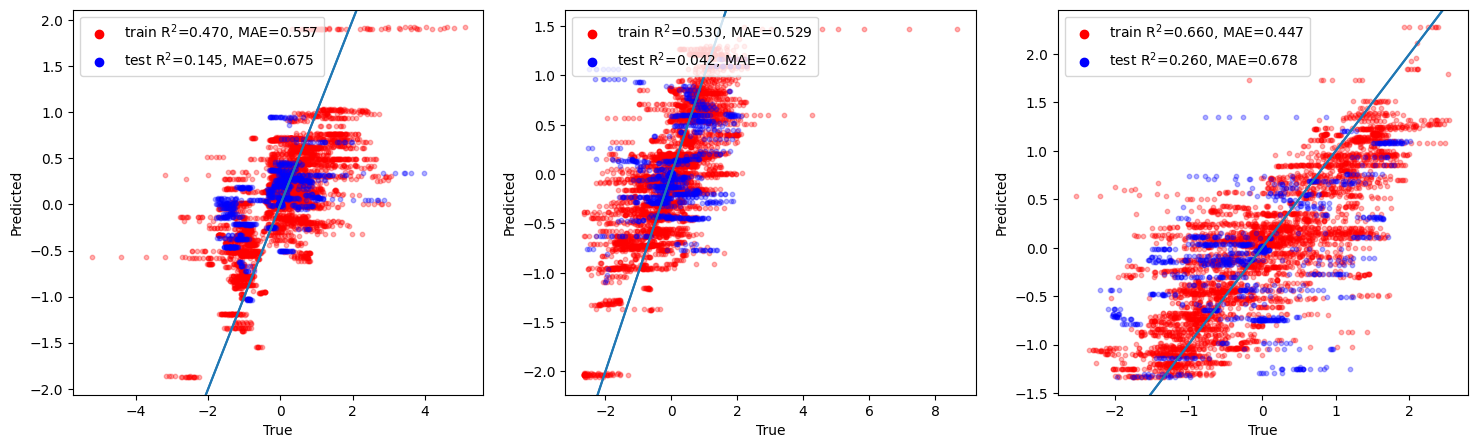

In [66]:
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = y_train_torch.shape[1], figsize = (y_train_torch.shape[1]*6,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred1, y_pred2, y_pred3 = model.forward(datax)
        y_pred1, y_pred2, y_pred3 = y_pred1.detach().cpu().numpy(), y_pred2.detach().cpu().numpy(), y_pred3.detach().cpu().numpy()
        y_pred = y_pred1, y_pred2, y_pred3
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred
        
        for i in range(y_train_torch.shape[1]):
        
            r2 = r2_score(y_true_norm[:,i], y_pred_norm[i])
            mae = mean_absolute_error(y_true_norm[:,i], y_pred_norm[i])

            ax[i].axline((1, 1), slope=1)

            ax[i].scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)


            ax[i].scatter(x=y_true_norm[:,i].ravel(), y=y_pred_norm[i].ravel(), c=c, alpha=0.3, s=10,
                       )

            #ax[i].set_title(f'{column}')
            ax[i].set_xlabel('True')
            ax[i].set_ylabel('Predicted')
            ax[i].legend(loc='upper left')

        #ax.set_xlim([-0.25, 3.5])
        #ax.set_ylim([-0.25, 3.5])

plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)